# In this Notebook  : 
We are going define classes to have a cleaner implementation and do more complex tasks with the plots.
We will have a usefull use of the interaction.

In [129]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

###  Class
We first define a **class** for the interaction to be cleaner. Doing so, we will be able to **store information**, and do backward actions on the ones which we've done before.

We just declare the class, **initialize** it (`__init__`) and define a `__call__` **function**. The **arguments** of the class are just a blank figure and an axe. In this notebook I use matplotlib **subplots** instead of just a figure, which allows more complex plots. You just need to know that the figure is the canvas, and the axes are the plots inside the canvas.

During the initialisation, we make the figure and the axes a property of the class (`self`), we plot the random plot we used before (see tutorial 1), and we create an empty list (`self.points`), which will store the points we add while clicking. We also link the interactive canvas to a press button action, as we used to. The only difference is that we don't link it to a specific function, but to `self`, which means the `__call__` function.

The call function will be called each time we click : it's the equivalent of the function we created in tutorial 1 defining what we wanted to do while interacting. 

Here, I kept the drawing color interaction. But now that we can store the added points, the right click (or `ctrl` click) will **remove the latest drawn point** !

# Try it :

In [2]:
class Interact:
    def __init__(self, fig, ax):
        self.ax = ax
        fig.canvas.mpl_connect('button_press_event', self)  # link the action (__call__) to the figure
        self.plot = plt.scatter(np.random.uniform(0, 10, 10), np.random.uniform(0, 10, 10))
        self.points = []

    def __call__(self, event):
        
            click_x = event.xdata  # get the clicking x coordinate
            click_y = event.ydata  # get the clicking y coordinate
            
            # We do the same function as in the basic tutorial :
            plt.title(f"I'm clicking on : (x, y) = ({click_x:.2f}, {click_y:.2f})")
            
            if (click_x > plt.xlim()[1]/2):
                color = 'red'
            else:
                color = 'blue'
            if event.button == 1:
                marker = 'o'
                # Now we add the clicked points to a list, so we can delete them later
                self.points.append(self.ax.scatter(event.xdata, event.ydata, marker=marker, c=color))
            
            # If we awre left clicking, we do another action : we remove the last created point
            if event.button == 3:
                try:
                    self.points[-1].remove()
                    self.points.pop(len(self.points)-1)
                    
                # Ff there is no more created points, print a message error
                except IndexError:
                    plt.title("Ooops, you want to remove a point but \n there is no more !")

<IPython.core.display.Javascript object>


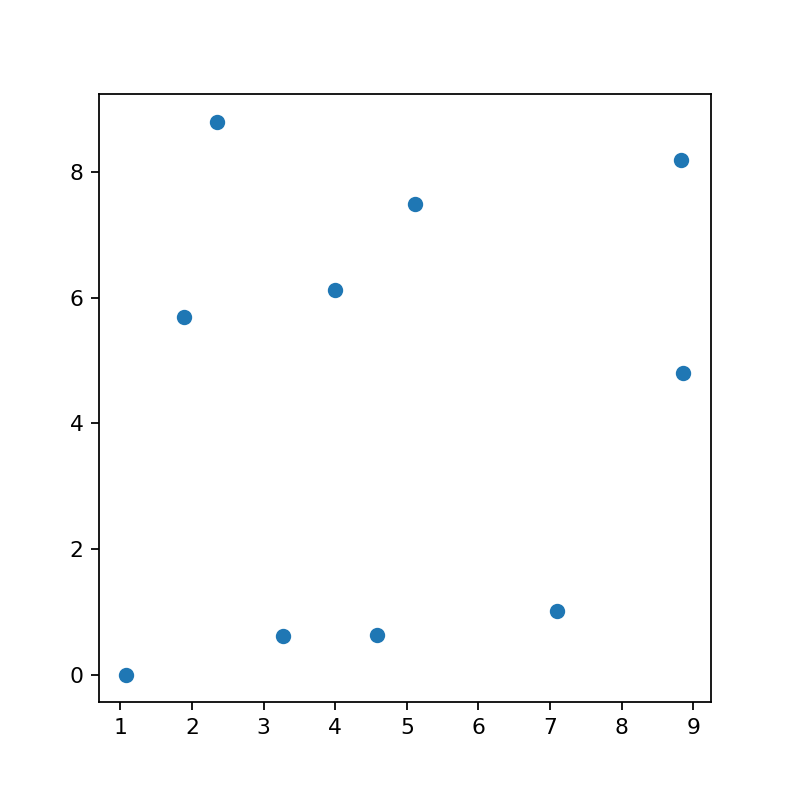

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))
interact = Interact(fig, ax)

### Cool right ?

Ok, now that we have the basis and a clean way to work, let's have our first usefull interactive plot.

We are going to plot a catalogue (let's play with galaxies, but you can use any table with more than 2 columns). The idea is to have a scatter plot of two of the parameters, and to print the values of an other parameter when clicking to the point of interest.

First, lets import the data : 

In [214]:
cat = np.load('../data/Galaxy_catalogue.npy', allow_pickle=True).item()

The catalogue is now stored in `cat`. It's a simple dictionnary containing 300 galaxies. For each galaxy (rows), we have 4 parameters (columns) : the magnitude `mag`, the radius and the ellipticity. The magnitude is an indicator of the brightness of a galaxy.

To do what we want, we first need a function to recognize the data point we are clicking. Don't look to much at the function, it's not the point of the notebook. 
Just for you to know, the function returns the closest data point to a clicked position on a graph. We will not necessarly need to click exactly on the point, this function will do the job for us. In addition, it returns the index of the corresponding data point, so we can print the other parameters of the galaxy.

In [215]:
from scipy.spatial import KDTree  # this is a method to find closest neighboors between two table

def find_closest_point(coords, cat, p1, p2):
    ''' 
        coords :  the clicked (x, y) coordinates we want to match to our catalogue
        cat : the catalogue to search in
        p1 : the parameter plotted on the x axis of the figure
        p1 : the parameter plotted on the y axis of the figure
        return : the catalog's index of the point closest to the clicked coordinate

    '''
    # Defining the table we want to match for
    searching_for = np.zeros((1, 2))
    searching_for[0, 0] = coords[0]
    searching_for[0, 1] = coords[1]

    # Defining the table we want to match with
    searching_in = np.zeros(((len(cat[next(iter(cat))]), 2)))
    searching_in[:, 0] = cat[p1]
    searching_in[:, 1] = cat[p2]
    
    # find the closest neighboor
    _, match_index = KDTree(searching_in).query(searching_for)
    
    closestx, closesty = searching_in[match_index][0]

    return match_index[0], closestx, closesty

# New Interaction !
Well let's do it ! The initialisation plots the radii of the galaxies wrt to their magnitude. Each time you'll click on the plot, the closest corresponding galaxy will be found, its color will changed, and its ellipticity will be printed on the title !

# Try it :

In [216]:
class Explore_catalogue:

    def __init__(self, fig, ax, cat, param1='mag', param2='radius', param3='ellipticity'):
        self.ax = ax
        self.param1 = param1  # Define the x axis
        self.param2 = param2  # Define the y axis
        self.param3 = param3  # Define the parameter you want to print while clicking
        
        self.cat = cat
        self.size_data = len(cat[param1])
        
        fig.canvas.mpl_connect('button_press_event', self)
    
        self.scatter_plot = ax.scatter(cat[param1], cat[param2], c="#1f77b4")  # plot the parameter 1 vs the parameter 2
#         self.sc_plot = self.plot_cat.scatter(cat[param1], cat[param2], s=5, c="#1f77b4")
        ax.set_xlabel(param1)
        ax.set_ylabel(param2)
        ax.set_title("It looks good : \n brighter galaxies (smaller magnitude) have bigger radius !",
                    fontsize=8)
        ax.set_axisbelow(True)  # put the grids behind the points
        plt.grid()
        
    def __call__(self, event):

        if event.button == 1:
            click_x = event.xdata
            click_y = event.ydata
            
            # Find the catalogue point the closest to the clicked one
            match_index, closest_x, closest_y = find_closest_point((click_x, click_y),
                                                                   self.cat,
                                                                   self.param1,
                                                                   self.param2)
            
            # Give the nearest point the color red
            colors = ["#1f77b4"] * self.size_data
            colors[match_index] = "red"
            self.scatter_plot.set_color(colors)
            
            # print the ellipticity of the clicked point
            self.ax.set_title(f"clicked point : ({click_x:.2f}, {click_y:.2f}) \n "+
                              f"closest point : ({closest_x:.2f}, {closest_y:.2f}) \n"+
                             f"corresponding ellipticity: {cat[self.param3][match_index]:.2f}")

<IPython.core.display.Javascript object>


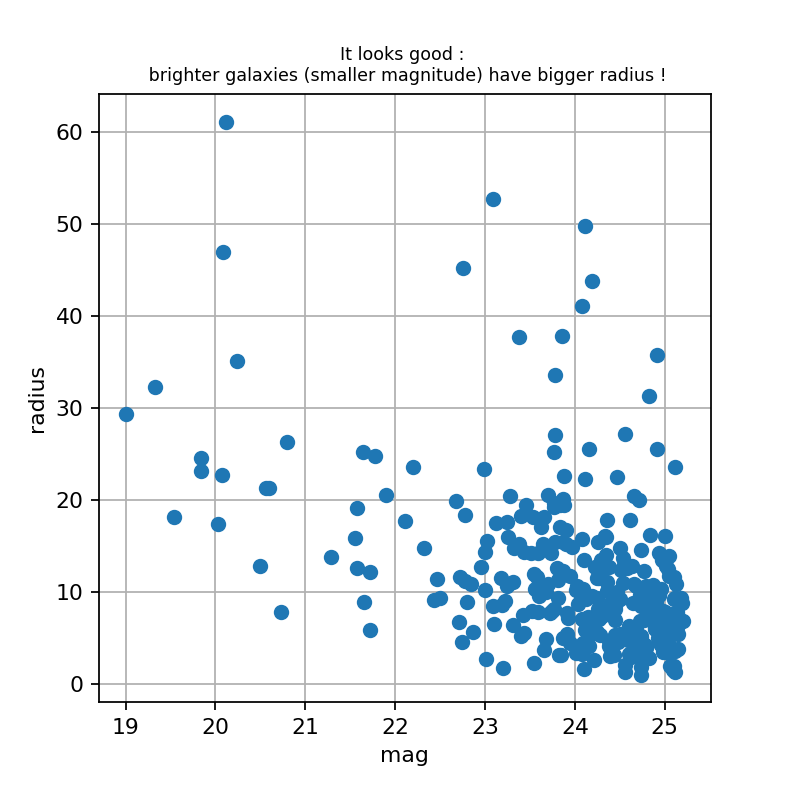

In [217]:
fig, ax = plt.subplots(figsize=(5, 5))
interact = Explore_catalogue(fig, ax, cat)


## Can be useful while exploring catalogs right ?
Well, of course you could have color-coded the ellipitcity, but you can always do that and use the interaction to print a 4th parameter !

# Let's add a cool behavior :
I want to plot the galaxy of the clicked point next to the scatter plot. Here I'll just use a simple analytic model to create galaxies (called a Sersic profile) parameterized by the magnitude, the radius and ellipticity. 
What can be cool, with exactly the same code, is to show the real images of your catalogue !

Final thing : If you left click anywhere in the plot, it will create a new galaxy with the clicked mag and radius, and a random ellipticity.

# Try it :

If you're not niterested in galaxy, you can skip this cell

In [295]:
def sersic_model(mag, rad, ell, n=1, size=64):

    x, y = np.meshgrid(np.arange(size), np.arange(size))  # create a 64 x 64 array

    a = rad / 2  # define the major axis of the galaxy
    b = (1-ell) * a  # define the minor axis of the galaxy, by taking into account the ellipticity
    
    z = np.sqrt(((x-(size/2)) / a) ** 2 + ((y-(size/2)) / b) ** 2)  # define the distance to center
    
    
    galaxy = 10**(-0.4*(mag-23.5)) * np.exp(-(2*n-1/3) * (z ** (1 / n) - 1))  # sersic profile
    
    galaxy = galaxy + np.random.normal(0, 0.25, (size, size))  # White noise

    return galaxy

In [302]:
class Explore_catalogue:
    def __init__(
        self, 
        fig, 
        ax, 
        cat, 
        param1='mag', 
        param2='radius', 
        param3='ellipticity',
    ):

        self.plot_cat = ax[0]  # define the left subplot, where the catalogue is plotted
        self.new_galaxies = [] 
        self.image = ax[1]     # define the right subplot, where the image is created
        self.param1 = param1
        self.param2 = param2
        self.param3 = param3
        self.cat = cat
        fig.canvas.mpl_connect('button_press_event', self)

        # plot the catlogue (radius versus magnitude)
        self.sc_plot = self.plot_cat.scatter(cat[param1], cat[param2], s=5, c="#1f77b4")
        self.plot_cat.set_xlabel(param1)
        self.plot_cat.set_ylabel(param2)
        self.size_data = len(cat[param1])

        # Reserve some space on top for the title
        fig.subplots_adjust(top=0.8)

    def __call__(self, event):

        click_x = event.xdata
        click_y = event.ydata

        if event.button == 1:
            match_index, closest_x, closest_y = find_closest_point(
                (click_x, click_y), 
                self.cat, 
                self.param1, 
                self.param2,
            )
            
            # Print infos on the title
            self.plot_cat.set_title(
                f"clicked (m): ({click_x:.2f}, {click_y:.2f}) \n" +
                f"closest point: ({closest_x:.2f}, {closest_y:.2f}) \n" +
                f"corresponding ellipticity: {cat[self.param3][match_index]:.2f}",
            )
            
            # Give the nearest point the color red
            colors = ["#1f77b4"] * self.size_data
            colors[match_index] = "red"
            self.sc_plot.set_color(colors)
            
            # Create and show galaxy with the corresponding parameters
            self.image.imshow(sersic_model(
                self.cat['mag'][match_index], 
                self.cat['radius'][match_index], 
                self.cat['ellipticity'][match_index],
            ))

        # If right click, it doesn't search for the closest point but create a new galaxy
        if event.button == 3:
            # Create and plot the galaxy
            self.new_galaxies.append(self.plot_cat.scatter(
                event.xdata, 
                event.ydata, 
                marker='*',  # change the marker style to distinguish between galaxies from the catalogue 
                c='red',     # and galaxies that we've created with a right click
            ))
            
            # Add info to the title
            self.plot_cat.set_title(f"new galaxy : ({click_x:.2f}, {click_y:.2f}) \n")
            self.image.imshow(sersic_model(click_x,
                                             click_y,
                                             np.random.uniform(0,1)))

<IPython.core.display.Javascript object>


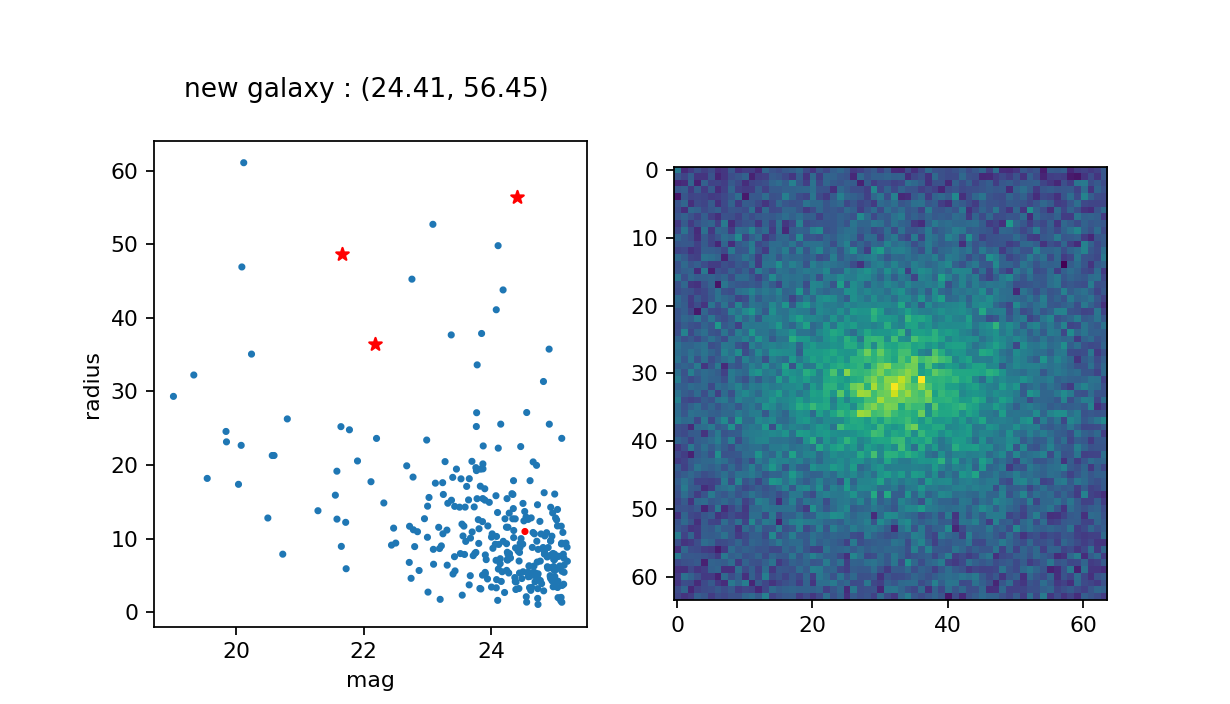

In [304]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
interact = Explore_catalogue(fig, ax, cat)

# It works !
 - The bigger the magnitude, the fainter is the galaxy (you can t even see it for big magnitude,
    it is drown on the noise... )
 - The bigger the radius, the bigger the galaxy
 - The bigger the ellipticity, the bigger the elongation

# The end !

We've seen a first interesting use of the event handling funciton of matplotlib. Remind you that you can now link any of your personal function to any of your plot ! I gave this very galaxy related example, but now, the floor is yours ! If you have ideas which can be intersting to be done here, let me know !

### Ps :
In the other codes, you'll learn how to use `ipywidgets`, and also to create a paint like python program !